In [ ]:
#install.packages("tidyverse")
#install.packages("rgdal")
#install.packages("spdep")
#install.packages("NipponMap")
#install.packages("sf")
#install.packages('raster')
#install.packages("here")
#install.packages("jpmesh")
#install.packages("devtools")
#install.packages("rmapshaper")
#install.packages("geojsonio")
#devtools::install_github("uribo/jpndistrict")
#install.packages('maptools')

In [ ]:
library(sf)
library(rgdal)
library(spdep)
library(NipponMap)
library(RColorBrewer)
library(raster)
library(tidyverse)
library(jpmesh)
library(rmapshaper)
library(geojsonsf)
library(maptools)

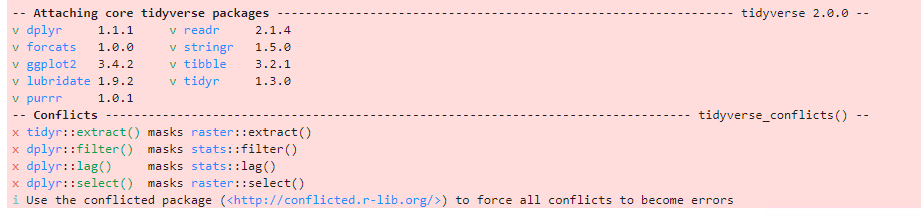

In [ ]:
ddir <- 'data/'

In [ ]:
# ファイルリスト
tif_202108 <- list.files(ddir
                         , pattern = "LC08_L1TP_107035_20210806_20210811_02_T1.+.TIF"
                         , full.names = TRUE)
# Band4,5をまとめてRasterStackクラスにする
tif_202108 <- stack(c(tif_202108[1], tif_202108[2]))
slotNames(tif_202108)  # 読み込んだラスタオブジェクトのスロット名を確認
tif_202108

In [ ]:
plot(tif_202108)

In [ ]:
tif_202108trans <- tif_202108
tif_202108trans<-projectRaster(tif_202108trans, crs=CRS("+init=epsg:6677"))  # 座標変換
tif_202108trans

In [ ]:
crs(tif_202108)
crs(tif_202108trans) <- CRS("+init=epsg:6677")  # crs情報を書き換え
cat("------")
crs(tif_202108trans)

In [ ]:
plot(tif_202108trans)

In [ ]:
cat('length', length(tif_202108trans), '\n')
cat('ncell', ncell(tif_202108trans), '\n')
cat('nrow', nrow(tif_202108trans), '\n')
cat('ncol', ncol(tif_202108trans), '\n')
cat("------")
raster::extent(tif_202108trans)
cat("------")
tif_202108trans

In [ ]:
#NDVIを計算する関数
calc_NDVI <- function(img, n, r) {
  red <- img[[r]]
  nir <- img[[n]]
  return ((nir-red) / (red + nir))
}

In [ ]:
#NDVIを計算する。NIR = 2, red = 1
ndvi <- calc_NDVI(tif_202108trans, 2, 1)
plot(ndvi)

In [ ]:
library(ggplot2)
ndvi.df <- as.data.frame(rasterToPoints(ndvi))
g <- ggplot(ndvi.df, aes(x=x, y=y)) + geom_tile(aes(fill = layer)) + coord_equal()
print(g)

In [ ]:
# shapeファイルリスト
shplists <- list.files(ddir, pattern = "*_220101*.shp", full.names = TRUE)

In [ ]:
# １番目のshapeファイルを読み込む。（茨城県）
prefs <- st_read(shplists[1])
prefs <- prefs %>% filter(!N03_004 %in% c("大島町", "利島村", "新島村", "神津島村", "三宅村", "御蔵島村", "八丈町", "青ヶ島村", "小笠原村", "所属未定地"))  # 島などは除外
prefsTr <- st_transform(prefs, crs=6677)
prefsTr

In [ ]:
# ２番目以降のshapeファイルを読み込み、マージする。（茨城県以外の関東地方都県）
for (i in shplists[-1]){
    s.sf0 <- st_read(i)
    s.sf0 <- s.sf0 %>% filter(!N03_004 %in% c("大島町", "利島村", "新島村", "神津島村", "三宅村", "御蔵島村", "八丈町", "青ヶ島村", "小笠原村", "所属未定地"))  # 島などは除外
    s.sf0 <- st_transform(s.sf0, crs=6677)
    #属性データは県名市名行政区域コードを残す
    prefsTr<-rbind(prefsTr[,c('N03_001','N03_004', 'N03_007')], s.sf0[,c('N03_001','N03_004', 'N03_007')])
    print(unique(s.sf0$N03_001))
}
prefsTr

In [ ]:
# shapeファイルplot
plot(prefsTr[,'N03_001'], axes=T)

In [ ]:
# shapeファイルplot
plot((prefsTr %>% na.omit() %>% filter(N03_001 %in% c('東京都','千葉県','神奈川県','埼玉県')))[,'N03_001'])# , axes=T

In [ ]:
ggplot(prefsTr[,'N03_001']) + geom_sf()

In [ ]:
# 大洗町も複数のレコードに分かれており、一部だけ抜き出してプロット
prefsTr_org2 <- (prefsTr_org %>% filter(N03_004 %in% c('大洗町')))
prefsTr_org2
plot(prefsTr_org2[,'N03_001'], axes=T, main='all')
for (i in (nrow(prefsTr_org2)-3):(nrow(prefsTr_org2)-1)) {
    plot(prefsTr_org2[i:i+1,'N03_001'], axes=T, main=i)#, add = T
}

In [ ]:
# 元データは残しておく
prefsTr_org <- st_as_sf(prefsTr)  # data.frameからsfクラスのデータを作成(念のため)
prefsTr_org$pref_city <- paste(prefsTr_org$N03_001, '_', prefsTr_org$N03_004)  # 県名＋市名

# 市町村単位のレコードにする
prefsTr <- st_as_sf(prefsTr)  # data.frameからsfクラスのデータを作成(念のため)
# 市町村単位でgroup_byしてsummariseすることで分割されていた市町村が統合される
prefsTr <- prefsTr %>% group_by(N03_001,N03_004) %>% summarise()
prefsTr$AREA <- prefsTr %>% st_area() %>% as.numeric()  # 市町村の面積
#prefsTr <- prefsTr %>% group_by(N03_001, N03_004) %>% slice_max(order_by = AREA, n = 1)
prefsTr$pref_city <- paste(prefsTr$N03_001, '_', prefsTr$N03_004)  # 県名＋市名
prefsTr

In [ ]:
# shpファイルplot
plot(st_geometry(prefsTr[,'pref_city']),axes=T)

In [ ]:
ggplot(prefsTr[,'pref_city']) + geom_sf()

In [ ]:
# 元のデータ
plot((prefsTr_org %>% filter(N03_004 %in% c('大洗町')))[,'N03_004'], main=paste('Original','大洗町'))
# 市町村単位のレコードにしたあとのデータ
prefsTr2 <- (prefsTr %>% filter(N03_004 %in% c('大洗町')))
plot(prefsTr2[,'AREA'], main=paste('GroupBy','大洗町'))

In [ ]:
for (i in unique(prefsTr$pref_city)) {
    #cat(i,'\n')
    prefsTr2 <- (prefsTr %>% filter(pref_city %in% c(i)))
    plot((prefsTr_org %>% filter(pref_city %in% c(i)))[,'N03_004'], main=paste('All',i))
    plot(prefsTr2[,'AREA'], main=paste('GroupBy',i))
}

In [ ]:
# NDVIラスタとシェープファイルベクターをオーバーレイ
croped<-crop(ndvi, prefsTr[,'pref_city'])
plot(croped)
plot(prefsTr[,'pref_city'], borders="white", col=NA, add=T)

In [ ]:
start <- proc.time()
#処理範囲をマスクする
masked<-mask(croped, prefsTr)
proc.time()-start

In [ ]:
writeRaster(masked, 'output/masked.tif', overwrite=TRUE)

In [ ]:
#masked<-raster('output/masked.tif')
#masked

In [ ]:
#表示して確認
plot(masked)
plot(prefsTr, borders="white", col=NA, add=T)

In [ ]:
# 欠損行削除
#prefsTrnonNan <- prefsTr[, 'N03_004', 'geometry'] %>% na.omit()
prefsTrnonNan <- na.omit(prefsTr)  # 島嶼部などが除外される
cat('length', length(prefsTr), '\n')
cat('ncell', ncell(prefsTr), '\n')
cat('nrow', nrow(prefsTr), '\n')
cat('ncol', ncol(prefsTr), '\n')
cat("------", '\n')
cat('length', length(prefsTrnonNan), '\n')
cat('ncell', ncell(prefsTrnonNan), '\n')
cat('nrow', nrow(prefsTrnonNan), '\n')
cat('ncol', ncol(prefsTrnonNan), '\n')
prefsTrnonNan

In [ ]:
# 欠損行削除後(ラスター on ベクター)
plot(st_geometry(prefsTrnonNan))
plot(masked, add=T)

In [ ]:
#表示して確認
plot(masked)
plot(prefsTrnonNan, borders="white", col=NA, add=T)

In [ ]:
prefsTr[187,]
plot(prefsTr[187,'N03_001'])

In [ ]:
#表示して確認
plot(st_geometry(prefsTrnonNan))
plot(masked, add=T)

In [ ]:
start <- proc.time()
#prefsTrnonNan <- as(prefsTrnonNan, "Spatial") # sf オブジェクトを sp へ
maskedex = raster::extract(masked, prefsTrnonNan, fun=mean, na.rm = TRUE)  # Rasterオブジェクトから平均値を抽出
prefsTrnonNanex <- prefsTrnonNan
prefsTrnonNanex$ndvi <- maskedex
prefsTrnonNanex <- st_as_sf(prefsTrnonNanex)  # data.frameからsfクラスのデータを作成
proc.time()-start

In [ ]:
str(prefsTrnonNan)  # 'sf' and 'data.frame'
cat('\n', '\n', "############################", '\n', '\n')
str(prefsTrnonNanex)  # 'sf' and 'data.frame'

In [ ]:
# 保存
st_write(prefsTrnonNanex, 'output/prefsTrnonNanex.shp', layer_options = "ENCODING=CP932", append=FALSE)

In [ ]:
#prefsTrnonNanex <- st_read('output/prefsTrnonNanex.shp', options = "ENCODING=CP932")
#prefsTrnonNanex

In [ ]:
# plotのカラースケール
nc <- 11
breaks <- seq(min(prefsTrnonNanex$ndvi %>% na.omit()), max(prefsTrnonNanex$ndvi %>% na.omit()), length.out = nc+1)
# cmap
pal <- (brewer.pal(n=nc, name="RdYlGn")) # 色を逆パターンがrev(brewer.pal(n=nc, name="RdYlGn"))
nvdiNonnan <- prefsTrnonNanex %>% na.omit()
plot(prefsTrnonNanex[, 'ndvi'], pal=pal, breaks=breaks)
plot(nvdiNonnan[, 'ndvi'], pal=pal, breaks=breaks)

In [ ]:
coords <- st_coordinates(st_centroid(nvdiNonnan)) # 重心確認
knn <- knearneigh(coords,4) # 最近隣4ゾーン
nb2 <- knn2nb(knn) # nb形式
w <- nb2listw(nb2) # listw
plot(st_geometry(nvdiNonnan), col='white')
plot(nb2, coords, add=TRUE, col='red', cex=0.5, lwd=2.)

In [ ]:
coords <- st_coordinates(st_centroid(nvdiNonnan)) # 重心確認
knn <- knearneigh(coords,4) # 最近隣4ゾーン
nb2 <- knn2nb(knn) # nb形式
w <- nb2listw(nb2) # listw
pop <- c(nvdiNonnan$ndvi)

In [ ]:
# モラン統計量
moran <- moran.test(pop, listw = w)
moran
moran <- moran.test(pop, listw = w, alternative = "less")
moran

In [ ]:
# 局所モラン統計量
?localmoran

In [ ]:
# 局所モラン統計量
lmoran <- localmoran(pop, listw = w)
lmoran[1:5,]

In [ ]:
head(nvdiNonnan)

In [ ]:
# 列追加
nvdiNonnan$lmoran <- lmoran[,"Ii"]  # local moran statistic
nvdiNonnan[,"lmoran"][1:5, ]

In [ ]:
# plotのカラースケール
maxval <- max(nvdiNonnan$lmoran)#max(max(nvdiNonnan$lmoran), abs(min(nvdiNonnan$lmoran)))
minxval <- min(nvdiNonnan$lmoran)#-1*max(max(nvdiNonnan$lmoran), abs(min(nvdiNonnan$lmoran)))
step <- (maxval-minxval) / 9#(maxval)*2 / nc
breaks <- seq(from = minxval
              , to = maxval
              , by = step)
# cmap
pal <- (brewer.pal(n=9, name="OrRd")) # 色を逆パターンがrev
# nvdiNonnanはshapeファイルなのでplotで自動的に日本地図のようにplotされる)
plot(nvdiNonnan[,"lmoran"], pal=pal, breaks=breaks)

In [ ]:
nvdiNonnan$lmoran_p <- lmoran[,"Pr(z != E(Ii))"]  # local moran statistic
# plotのカラースケール
breaks <- c(0, 0.01, 0.05, 0.1, 1)
nc_p <- length(breaks) - 1
# cmap
pal <- rev(brewer.pal(n=nc_p, name="RdPu")) # 色を逆パターンがrev
# nvdiNonnanはshapeファイルなのでplotで自動的に日本地図のようにplotされる)
plot(nvdiNonnan[,"lmoran_p"], pal=pal, breaks=breaks)

In [ ]:
# moran散布図
moran.plot(pop, listw = w, labels = nvdiNonnan$pref_city, pch=20)

In [ ]:
#nvdiNonnan
plot(nvdiNonnan$lmoran, nvdiNonnan$ndvi, xlab="lmoran", ylab="ndvi")
pointLabel(x=nvdiNonnan$lmoran[seq(from = 1, to = length(nvdiNonnan$lmoran), by = 8)]
           , y=nvdiNonnan$ndvi[seq(from = 1, to = length(nvdiNonnan$ndvi), by = 8)]
           , labels=nvdiNonnan$pref_city[seq(from = 1, to = length(nvdiNonnan$pref_city), by = 8)],cex=0.8)

In [ ]:
# G/G*統計量
# G統計量は空間集積の検定統計量(空間的に偏っているか)
# include.self関数は対角項を1に
w_b <- nb2listw(include.self(nb2), style='B') # 近接行列
Gstar <- globalG.test(pop, listw=w_b)
Gstar
Gstar <- globalG.test(pop, listw=w_b, alternative = "less")
Gstar

In [ ]:
# ローカルG/G*統計量
# G統計量は空間集積の検定統計量(空間的に偏っているか)
# include.self関数は対角項を1に
w_b2 <- nb2listw(include.self(nb2)) # 近接行列
# Local G*
lG <- localG(pop, listw = w_b2)
# 可視化
nvdiNonnan$lG <- lG

#maxval <- max(max(nvdiNonnan$lG), abs(min(nvdiNonnan$lG)))
#minxval <- -1*max(max(nvdiNonnan$lG), abs(min(nvdiNonnan$lG)))
#step <- (maxval)*2 / nc
#breaks <- seq(from = minxval
#              , to = maxval
#              , by = step)

# cmap
breaks <- c(-5, -2.58, -1.96, -1.65, 0, 1.65, 1.96, 2.58, 5)
pal <- rev(brewer.pal(n=length(breaks)-1, name="RdBu")) # 色を逆パターンがrev
graphics::plot(nvdiNonnan[,"lG"], pal=pal, breaks=breaks)

In [ ]:
#nvdiNonnan
plot(nvdiNonnan$lmoran, nvdiNonnan$lG, xlab="lmoran", ylab="lG")
pointLabel(x=nvdiNonnan$lmoran[seq(from = 1, to = length(nvdiNonnan$lmoran), by = 8)]
           , y=nvdiNonnan$lG[seq(from = 1, to = length(nvdiNonnan$lG), by = 8)]
           , labels=nvdiNonnan$pref_city[seq(from = 1, to = length(nvdiNonnan$pref_city), by = 8)],cex=0.8)